In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:

# --- 1. Load Feature Names ---
# This step is needed to get the 'features' variable you used.
# We read the 2nd column (index 1) from features.txt.
try:
    features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
    feature_names = features_df[1].tolist()
except FileNotFoundError:
    print("Error: 'features.txt' not found. Make sure it's in the 'UCI HAR Dataset' folder.")
    # You would typically exit or handle this error, but for demonstration:
    feature_names = [] # Set to empty list to show the error

# --- 2. Load Training Data (X_train) ---
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Set the column names
if feature_names:
    X_train.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: Feature names not loaded. Columns will be numbered.")

# --- 3. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None)[0]

# --- 4. Load Activity Labels (y_train) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_train_series = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['Activity'])['Activity']

# --- 5. Combine All Data into One DataFrame ---
# It's good practice to copy X_train to avoid modifying the original
train = X_train.copy()

# Add the new columns
train['subject'] = subject_series
train['Activity'] = y_train_series

# --- 6. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

train['ActivityName'] = train['Activity'].map(activity_map)

# --- 7. Display a Sample ---
# Using .head() or .sample() is a great way to check your work
print("Data loaded successfully. Displaying first few data set:")
train.head(2)



C:\Users\new user\AppData\Local\Temp\ipykernel_21920\1967201394.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
C:\Users\new user\AppData\Local\Temp\ipykernel_21920\1967201394.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


Data loaded successfully. Displaying first few data set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


In [3]:
# --- 1. Load Test Data (X_test) ---
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)

# Set the column names
if 'feature_names' in locals():
    X_test.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: 'feature_names' not found. Columns will be numbered.")

# --- 2. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series_test = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None)[0]

# --- 3. Load Activity Labels (y_test) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_test_series = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['Activity'])['Activity']

# --- 4. Combine All Data into One DataFrame ---
# Use .copy() to prevent SettingWithCopyWarning
test = X_test.copy()

# Add the new columns
test['subject'] = subject_series_test
test['Activity'] = y_test_series

# --- 5. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

test['ActivityName'] = test['Activity'].map(activity_map)

# --- 6. Display a Sample ---
print("Test data loaded successfully. Displaying a random sample:")
print(test.head(2))


C:\Users\new user\AppData\Local\Temp\ipykernel_21920\2637941692.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


Test data loaded successfully. Displaying a random sample:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  angle(tBodyAccMean,gravity)  \
0         -0.674302         -0.894088  ...                     0.006462   
1         -0.945823         -0.894088  ...                    -0.083495   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                               0.16292                         -0.825886   
1                               0.01750                         -0.434375   

   angle(t

In [4]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


In [5]:
#Labels that are useful in plotting confusion matrix
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
#Let's make a function to plot the confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    
    # --- THIS IS THE FIX ---
    plt.grid(False) # Changed from plt.grid(b=False)
    # -----------------------
    
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

In [6]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))

    

Running GridSearchCV for RandomForestClassifier...
training the model..
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Done....!

==> training time:- 0:00:35.041144

Predicting test data
Done....!

==> testing time:- 0:00:00.013541

==> Accuracy:- 0.9192399049881235


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 423  68   0   0   0]
 [  0  37 495   0   0   0]
 [  0   0   0 484   9   3]
 [  0   0   0  28 350  42]
 [  0   0   0  45   6 420]]


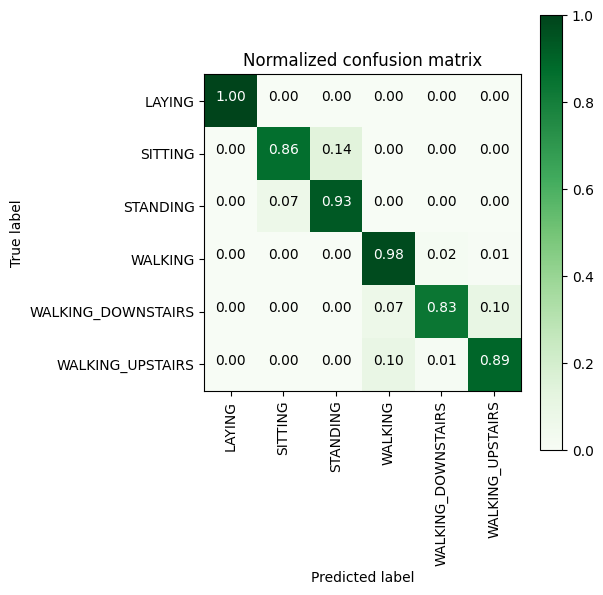

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.86      0.89       491
          STANDING       0.88      0.93      0.90       532
           WALKING       0.87      0.98      0.92       496
WALKING_DOWNSTAIRS       0.96      0.83      0.89       420
  WALKING_UPSTAIRS       0.90      0.89      0.90       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 50}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 3

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9124060

In [8]:
print('Running GridSearchCV for RandomForestClassifier...')

# 1. Define the parameters for Random Forest
# This grid is kept small to run reasonably fast.
# 'n_estimators' = number of trees in the forest
# 'max_depth'    = max levels in each tree
parameters = {
    'n_estimators': [50, 100, 200],  # Try 3 different forest sizes
    'max_depth': [10, 20, None]      # Try 2 depths + one with no limit
}

# 2. Create the model instance
# random_state=42 ensures you get the same results every time you run it
rf_model = RandomForestClassifier(random_state=42)

# 3. Set up the GridSearchCV
rf_grid = GridSearchCV(
    rf_model,
    param_grid=parameters,
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

# 4. Run the model and get results (using your existing function)
# Assumes X_train, y_train, X_test, y_test, and labels are all loaded
rf_grid_results = perform_model(
    rf_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    class_labels=labels
)

# 5. Print the best-found parameters
print_grid_search_attributes(rf_grid_results['model'])


--- Feature Importances from Random Forest ---


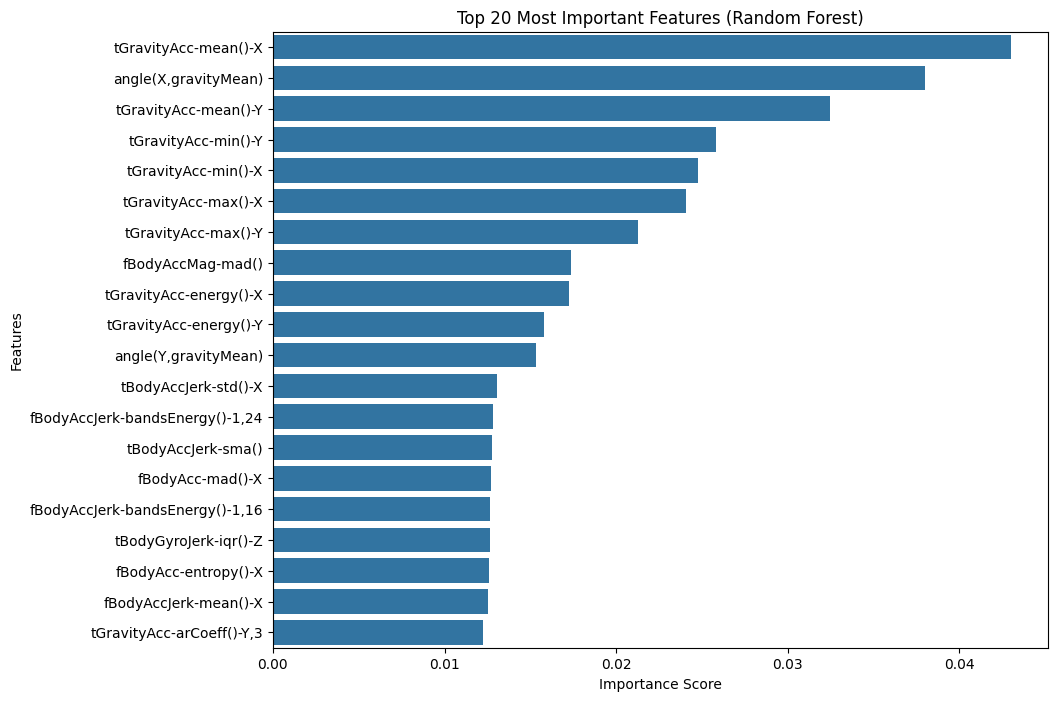

tGravityAcc-mean()-X               0.043005
angle(X,gravityMean)               0.037966
tGravityAcc-mean()-Y               0.032468
tGravityAcc-min()-Y                0.025808
tGravityAcc-min()-X                0.024797
tGravityAcc-max()-X                0.024052
tGravityAcc-max()-Y                0.021289
fBodyAccMag-mad()                  0.017356
tGravityAcc-energy()-X             0.017236
tGravityAcc-energy()-Y             0.015806
angle(Y,gravityMean)               0.015325
tBodyAccJerk-std()-X               0.013035
fBodyAccJerk-bandsEnergy()-1,24    0.012811
tBodyAccJerk-sma()                 0.012788
fBodyAcc-mad()-X                   0.012713
fBodyAccJerk-bandsEnergy()-1,16    0.012666
tBodyGyroJerk-iqr()-Z              0.012664
fBodyAcc-entropy()-X               0.012607
fBodyAccJerk-mean()-X              0.012539
tGravityAcc-arCoeff()-Y,3          0.012218
dtype: float64


In [9]:
import seaborn as sns
print('\n--- Feature Importances from Random Forest ---')

# Get the best-performing model from the grid search
best_rf_model = rf_grid_results['model'].best_estimator_

# Get the feature importances
importances = best_rf_model.feature_importances_

# Create a pandas Series to associate importances with feature names
# This assumes your X_train is a DataFrame with feature names in the columns
# If X_train is a numpy array, you'd need your list of 'feature_names'
feature_importances = pd.Series(importances, index=X_train.columns)

# Sort by importance (highest first) and get the top 20
top_20_features = feature_importances.nlargest(20)

# --- Plot the Top 20 Features ---
plt.figure(figsize=(10, 8))
sns.barplot(x=top_20_features.values, y=top_20_features.index)
plt.title('Top 20 Most Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(top_20_features)

In [10]:
# --- Assuming 'rf_grid_results' is the output of your last run ---

print("--- Extracting Top 50 Features ---")

# 1. Get the best model from the grid search
best_rf_model = rf_grid_results['model'].best_estimator_

# 2. Get feature importances
importances = best_rf_model.feature_importances_

# 3. Create a Series with feature names
#    (Assumes X_train is a pandas DataFrame with column names)
feature_importances = pd.Series(importances, index=X_train.columns)

# 4. Get the names of the top 20 features and store in a list
top_50_features_list = feature_importances.nlargest(50).index.tolist()

print(f"Top 50 features found: \n{top_50_features_list}\n")

--- Extracting Top 50 Features ---
Top 50 features found: 
['tGravityAcc-mean()-X', 'angle(X,gravityMean)', 'tGravityAcc-mean()-Y', 'tGravityAcc-min()-Y', 'tGravityAcc-min()-X', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y', 'fBodyAccMag-mad()', 'tGravityAcc-energy()-X', 'tGravityAcc-energy()-Y', 'angle(Y,gravityMean)', 'tBodyAccJerk-std()-X', 'fBodyAccJerk-bandsEnergy()-1,24', 'tBodyAccJerk-sma()', 'fBodyAcc-mad()-X', 'fBodyAccJerk-bandsEnergy()-1,16', 'tBodyGyroJerk-iqr()-Z', 'fBodyAcc-entropy()-X', 'fBodyAccJerk-mean()-X', 'tGravityAcc-arCoeff()-Y,3', 'tGravityAcc-mean()-Z', 'tGravityAccMag-mad()', 'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-min()-Z', 'tBodyAcc-max()-X', 'angle(Z,gravityMean)', 'fBodyAccJerk-bandsEnergy()-1,16', 'fBodyAccMag-energy()', 'fBodyAccJerk-max()-X', 'tBodyAccJerkMag-energy()', 'tBodyAccJerk-mad()-Y', 'tGravityAccMag-arCoeff()1', 'tBodyAccJerk-energy()-X', 'tBodyAccJerk-iqr()-X', 'tGravityAcc-entropy()-Y', 'tBodyGyroJerk-iqr()-X', 'tBodyAccMag-std()', 'fBodyAc

In [11]:
def run_model_on_selected_features(
    base_model,           # e.g., RandomForestClassifier()
    param_grid,           # The parameters for grid search
    feature_list,         # The list of feature names to use
    X_train_full,         # The original, full X_train
    y_train,              # The y_train
    X_test_full,          # The original, full X_test
    y_test,               # The y_test
    class_labels):        # The list of your activity names
    
    """
    This function takes a list of features, creates new datasets,
    and re-runs the full grid search and model performance analysis
    using only those features.
    """
    
    print("="*50)
    print(f"--- Re-training Model on {len(feature_list)} Selected Features ---")
    print("="*50)

    # 1. Create the new, smaller DataFrames
    X_train_selected = X_train_full[feature_list]
    X_test_selected = X_test_full[feature_list]
    
    print(f"New training data shape: {X_train_selected.shape}")
    
    # 2. Set up a new GridSearchCV for this specific run
    # We re-gridsearch because the optimal parameters might change on fewer features
    grid_search = GridSearchCV(
        base_model,
        param_grid=param_grid,
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    
    # 3. Call your original 'perform_model' function
    #    using the new, smaller datasets
    results = perform_model(
        grid_search,
        X_train_selected,  # <-- Pass the selected features
        y_train,
        X_test_selected,   # <-- Pass the selected features
        y_test,
        class_labels=class_labels
    )
    
    # 4. Print the new grid search attributes
    print_grid_search_attributes(results['model'])
    
    return results

--- Re-training Model on 50 Selected Features ---
New training data shape: (7352, 58)
training the model..
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Done....!

==> training time:- 0:00:14.357983

Predicting test data
Done....!

==> testing time:- 0:00:00.038257

==> Accuracy:- 0.8717339667458432


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 385 106   0   0   0]
 [  0  96 436   0   0   0]
 [  0   0   0 464   4  28]
 [  0   0   0  19 346  55]
 [  0   0   0  63   7 401]]


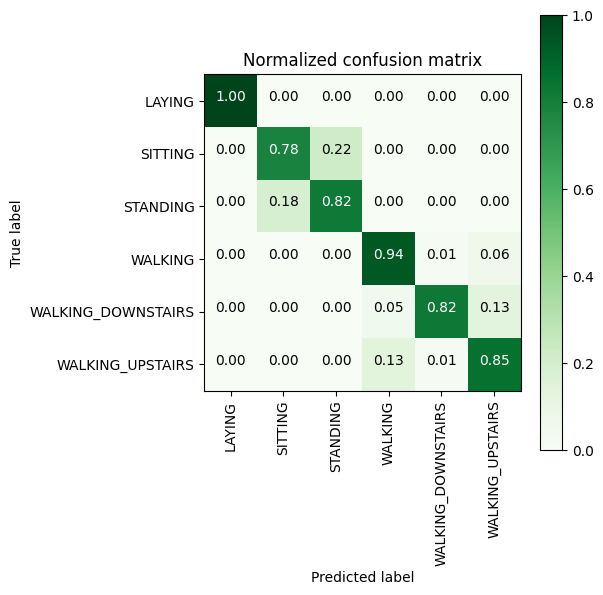

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.80      0.78      0.79       491
          STANDING       0.80      0.82      0.81       532
           WALKING       0.85      0.94      0.89       496
WALKING_DOWNSTAIRS       0.97      0.82      0.89       420
  WALKING_UPSTAIRS       0.83      0.85      0.84       471

          accuracy                           0.87      2947
         macro avg       0.88      0.87      0.87      2947
      weighted avg       0.87      0.87      0.87      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 20, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 3

==> Best Score:
	Average Cross Validate scores of best estimator : 0.89268

In [12]:
# --- 1. Define the base model and params you want to test again ---
#    (These are the same as before)
rf_base_model = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

# --- 2. Run the new function ---
# This will re-run the *entire* process using only the top 20 features
# and will print a new confusion matrix and report.

rf_top20_results = run_model_on_selected_features(
    rf_base_model,
    rf_params,
    top_50_features_list, # <-- The list we generated in Step 1
    X_train,              # <-- The original full data
    y_train,
    X_test,               # <-- The original full data
    y_test,
    labels                # <-- Your 'labels' list
)

# --- 3. Now you can compare! ---
print("\n\n" + "="*70)
print("--- Performance Comparison ---")
print(f"Accuracy (All 561 Features): {rf_grid_results['accuracy'] * 100:.2f}%")
print(f"Accuracy (Top 200 Features): {rf_top20_results['accuracy'] * 100:.2f}%")
print("="*70)

# LOGISTIC REGRESSION

training the model..
Done....!

==> training time:- 0:03:17.125823

Predicting test data
Done....!

==> testing time:- 0:00:00.010836

==> Accuracy:- 0.9307770614183916


 ********Confusion Matrix********

 [[534   0   3   0   0   0]
 [  0 425  63   0   0   3]
 [  0  35 497   0   0   0]
 [  0   0   0 483   9   4]
 [  0   0   0   7 380  33]
 [  0   0   0  31  16 424]]


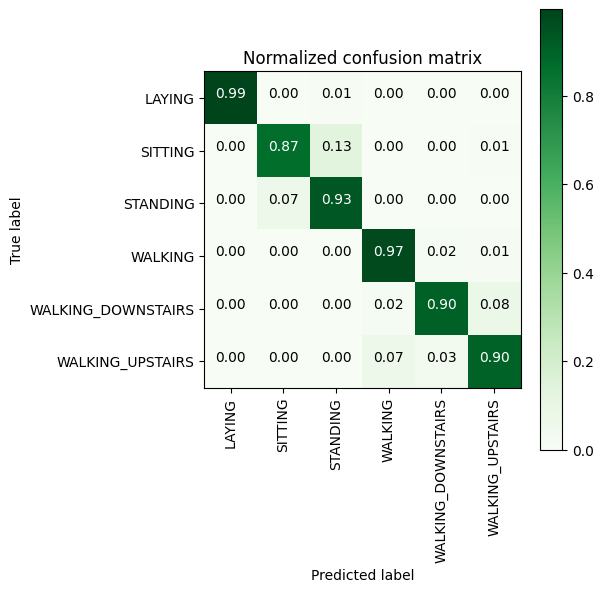

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.92      0.87      0.89       491
          STANDING       0.88      0.93      0.91       532
           WALKING       0.93      0.97      0.95       496
WALKING_DOWNSTAIRS       0.94      0.90      0.92       420
  WALKING_UPSTAIRS       0.91      0.90      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.93      0.93      2947
      weighted avg       0.93      0.93      0.93      2947



In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# 1. Create the pipeline
# This is a list of steps: ('name_of_step', object_to_run)
# Create a pipeline that scales, runs PCA, then models
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # Keep 95% of the variance
    ('pca', PCA(n_components=0.95)), 
    ('model', LogisticRegression(max_iter=1000))
])
# 2. Set up GridSearch... on the PIPELINE
#
# *** THIS IS THE KEY PART ***
# You must tell GridSearch *which step* in the pipeline to apply the parameters to.
# You use the name you chose ('model') followed by __ (two underscores).
# --- 1. Define the C values to test ---
C_values = [0.01, 0.1, 1, 10, 100]

# --- 2. Create the list of parameter grids ---

# Grid 1: Test 'lbfgs' (the default) with 'l2' penalty
# This is a good, fast, all-around solver.
grid_1 = {
    'model__solver': ['lbfgs'],
    'model__penalty': ['l2'],
    'model__C': C_values,
    'model__max_iter': [1000]  # Increase from default 100 to ensure convergence
}

# Grid 2: Test 'liblinear' (the one you mentioned)
# This is often best for smaller datasets and supports 'l1' (Lasso).
# 'l1' is great because it can force unimportant features to zero.
grid_2 = {
    'model__solver': ['liblinear'],
    'model__penalty': ['l1', 'l2'], # Test BOTH penalties
    'model__C': C_values,
    'model__max_iter': [1000]
}

# Grid 3: Test 'saga' (a more advanced solver)
# 'saga' is good for large datasets and supports both penalties.
# It often needs more iterations.
grid_3 = {
    'model__solver': ['saga'],
    'model__penalty': ['l1', 'l2'],
    'model__C': C_values,
    'model__max_iter': [3000, 5000] # 'saga' needs more iterations
}

# --- 3. Combine the grids into a list ---
parameters_log_reg = [grid_1, grid_2, grid_3]
log_reg_grid = GridSearchCV(
    pca_pipeline,        # <-- Pass the whole pipeline here
    param_grid=parameters_log_reg,
    cv=3,
    n_jobs=-1
)

# 3. Call your function (it works perfectly, no changes needed)
log_reg_grid_results = perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# SVM

Running GridSearchCV for SVM (SVC)...
training the model..
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Done....!

==> training time:- 0:00:41.772152

Predicting test data
Done....!

==> testing time:- 0:00:00.070522

==> Accuracy:- 0.9216152019002375


 ********Confusion Matrix********

 [[536   0   1   0   0   0]
 [  3 422  65   0   0   1]
 [  0  39 493   0   0   0]
 [  0   0   0 479  13   4]
 [  0   0   0   7 373  40]
 [  0   0   0  31  27 413]]


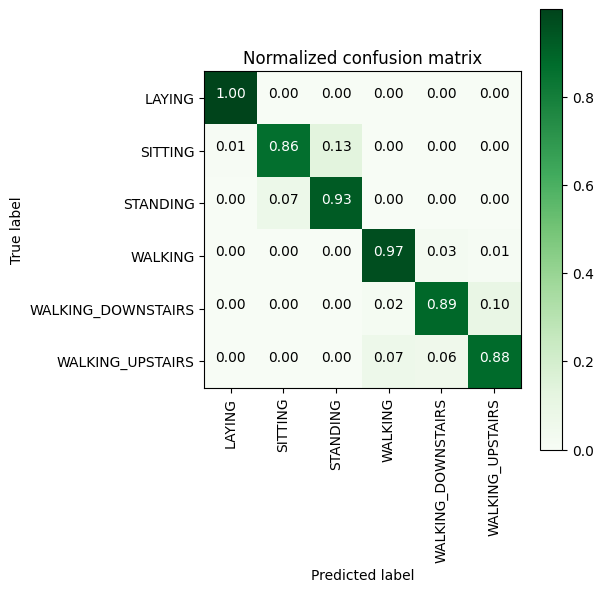

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.92      0.86      0.89       491
          STANDING       0.88      0.93      0.90       532
           WALKING       0.93      0.97      0.95       496
WALKING_DOWNSTAIRS       0.90      0.89      0.90       420
  WALKING_UPSTAIRS       0.90      0.88      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



In [14]:
from sklearn.svm import SVC


# --- 1. Create the SVM pipeline ---
# This is identical to your Logistic Regression pipeline,
# just swapping the model for 'SVC'.
# We add cache_size=500 to speed up training.
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('model', SVC(cache_size=500))     # 'model' is our step name
])


# --- 2. Create the list of parameter grids ---
# We use the same C values you had before
C_values = [0.01, 0.1, 1, 10, 100]

# Grid 1: Test the 'linear' kernel
# This is fast and powerful if the data is linearly separable (after PCA).
# A 'linear' kernel only needs the 'C' parameter.
grid_1 = {
    'model__kernel': ['linear'],
    'model__C': C_values
}

# Grid 2: Test the 'rbf' (Radial Basis Function) kernel
# This is the powerful, non-linear "default" kernel.
# It can create complex boundaries but needs to tune 'gamma' as well.
grid_2 = {
    'model__kernel': ['rbf'],
    'model__C': C_values,
    'model__gamma': ['scale', 0.1, 0.01]  # 'scale' is a smart default
}

# --- 3. Combine the grids into a list ---
parameters_svm = [grid_1, grid_2]

# --- 4. Set up your GridSearchCV ---
print("Running GridSearchCV for SVM (SVC)...")

svm_grid = GridSearchCV(
    svm_pipeline,               # <-- Pass the SVM pipeline
    param_grid=parameters_svm,  # <-- Pass the LIST of grids
    cv=3,
    verbose=1,                  # 'verbose=1' will give you updates
    n_jobs=-1                   # Use all available cores
)

# --- 5. Call your function (no changes needed) ---
# This will now test all combinations from grid_1 AND grid_2
# and find the single best SVM model.
svm_grid_results = perform_model(svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# print_grid_search_attributes(svm_grid_results['model'])

Running GridSearchCV for SVM (all 4 kernels)...
training the model..
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Done....!

==> training time:- 0:00:14.898455

Predicting test data
Done....!

==> testing time:- 0:00:00.069593

==> Accuracy:- 0.9216152019002375


 ********Confusion Matrix********

 [[536   0   1   0   0   0]
 [  3 422  65   0   0   1]
 [  0  39 493   0   0   0]
 [  0   0   0 479  13   4]
 [  0   0   0   7 373  40]
 [  0   0   0  31  27 413]]


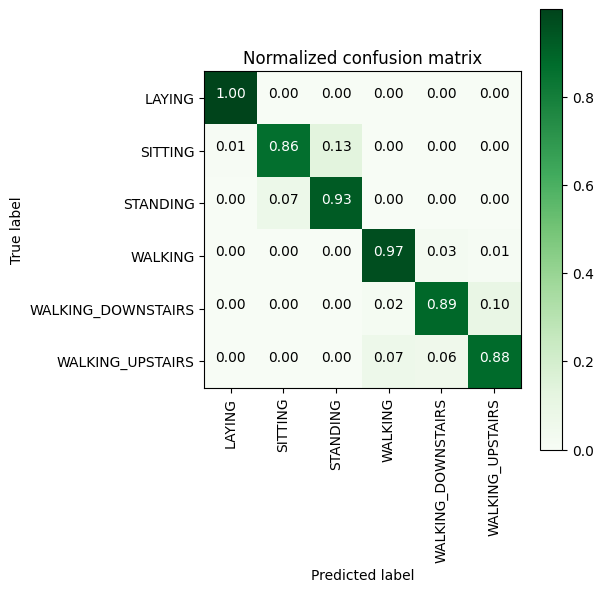

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.92      0.86      0.89       491
          STANDING       0.88      0.93      0.90       532
           WALKING       0.93      0.97      0.95       496
WALKING_DOWNSTAIRS       0.90      0.89      0.90       420
  WALKING_UPSTAIRS       0.90      0.88      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



In [15]:
# --- Your C values ---
C_values = [0.1, 1, 10]  # Reduced C list to run faster

# --- Your pipeline (no change) ---
# svm_pipeline = Pipeline([ ... ])

# Grid 1: Test the 'linear' kernel
grid_1 = {
    'model__kernel': ['linear'],
    'model__C': C_values
}

# Grid 2: Test the 'rbf' (Gaussian) kernel
grid_2 = {
    'model__kernel': ['rbf'],
    'model__C': C_values,
    'model__gamma': ['scale', 0.1]
}

# --- NEW GRIDS ---

# Grid 3: Test the 'poly' (Polynomial) kernel
# We must tune 'degree' and 'coef0'
grid_3 = {
    'model__kernel': ['poly'],
    'model__C': C_values,
    'model__degree': [2, 3],          # Test 2nd and 3rd degree
    'model__coef0': [0, 1]            # Offset, 0 or 1 is common
}

# Grid 4: Test the 'sigmoid' kernel
# We must tune 'coef0'
grid_4 = {
    'model__kernel': ['sigmoid'],
    'model__C': C_values,
    'model__coef0': [0, 1]
}

# --- 3. Combine ALL grids into a list ---
parameters_svm = [grid_1, grid_2, grid_3, grid_4]

# --- 4. Set up your GridSearchCV ---
print("Running GridSearchCV for SVM (all 4 kernels)...")

svm_grid = GridSearchCV(
    svm_pipeline,               
    param_grid=parameters_svm,  # Pass the LIST of all 4 grids
    cv=3,
    verbose=1,
    n_jobs=-1
)
svm_grid_results = perform_model(svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)
# ... then run your perform_model() function ...
# svm_grid_results = perform_model(svm_grid, ...)

training the model..
Done....!

==> training time:- 0:02:46.411894

Predicting test data
Done....!

==> testing time:- 0:00:00.781389

==> Accuracy:- 0.9626739056667798


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


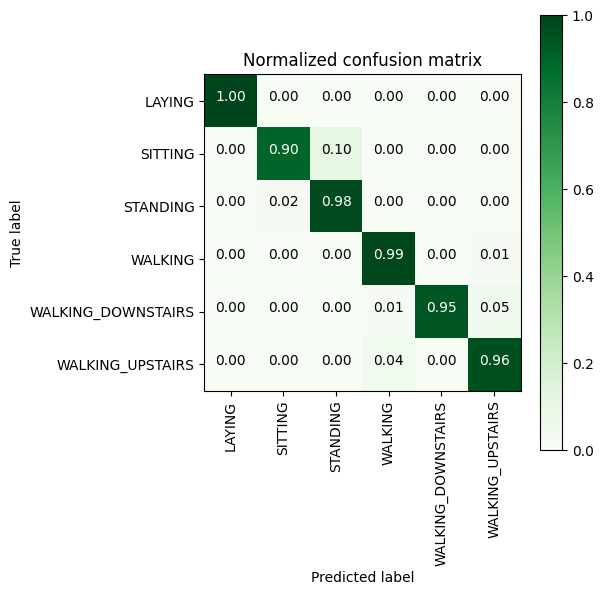

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	SVC(C=16, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 16, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9447834551903698


In [16]:
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rbf_svm_grid_results['model'])

# Linear SVM

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Done....!

==> training time:- 0:00:15.262946

Predicting test data
Done....!

==> testing time:- 0:00:00.007797

==> Accuracy:- 0.9667458432304038


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  2 428  58   0   0   3]
 [  0   9 522   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   3 412   5]
 [  0   0   0  17   0 454]]


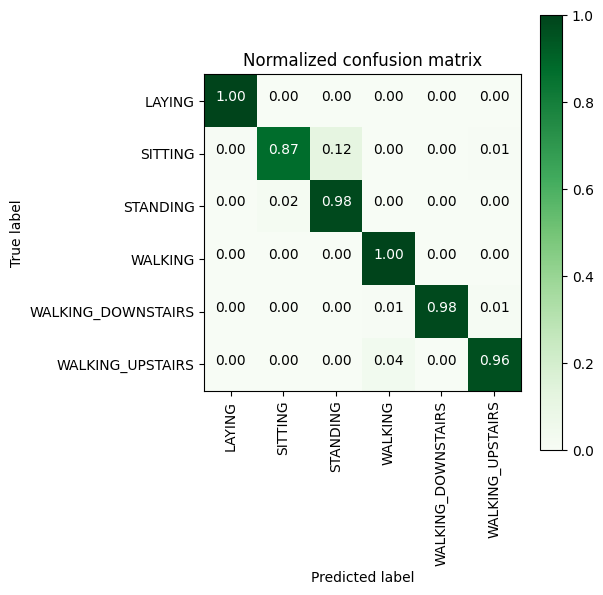

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.87      0.92       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



==> Best Estimator:
	LinearSVC(C=0.5, tol=5e-05)


==> Best parameters:
	Parameters of best estimator : {'C': 0.5}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.9419282546465222


In [17]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(lr_svc_grid_results['model'])

training the model..
Done....!

==> training time:- 0:02:57.130591

Predicting test data
Done....!

==> testing time:- 0:00:00.028524

==> Accuracy:- 0.9216152019002375


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 425  66   0   0   0]
 [  0  43 489   0   0   0]
 [  0   0   0 481  12   3]
 [  0   0   0  23 353  44]
 [  0   0   0  34   6 431]]


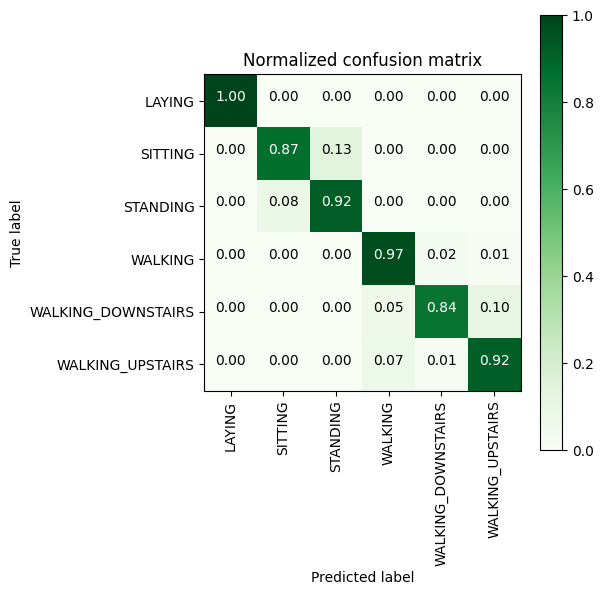

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.87      0.89       491
          STANDING       0.88      0.92      0.90       532
           WALKING       0.89      0.97      0.93       496
WALKING_DOWNSTAIRS       0.95      0.84      0.89       420
  WALKING_UPSTAIRS       0.90      0.92      0.91       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=np.int64(11), n_estimators=np.int64(90))


==> Best parameters:
	Parameters of best estimator : {'max_depth': np.int64(11), 'n_estimators': np.int64(90)}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of bes

In [18]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])

# KNN

Running GridSearchCV for K-Nearest Neighbors (KNN)...
training the model..
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.85310275 0.85446301 0.86344    0.86411993 0.86888112 0.86874501
 0.87010516 0.86996916 0.87024133 0.87105738        nan 0.85378119
        nan 0.85990258        nan 0.86806479        nan 0.87132871
        nan 0.87105666]
  warnings.warn(


Done....!

==> training time:- 0:00:08.094406

Predicting test data
Done....!

==> testing time:- 0:00:00.202336

==> Accuracy:- 0.8737699355276553


 ********Confusion Matrix********

 [[503  17  17   0   0   0]
 [  2 353 134   0   0   2]
 [  0  30 502   0   0   0]
 [  0   0   0 490   5   1]
 [  0   0   0  61 300  59]
 [  0   0   0  39   5 427]]


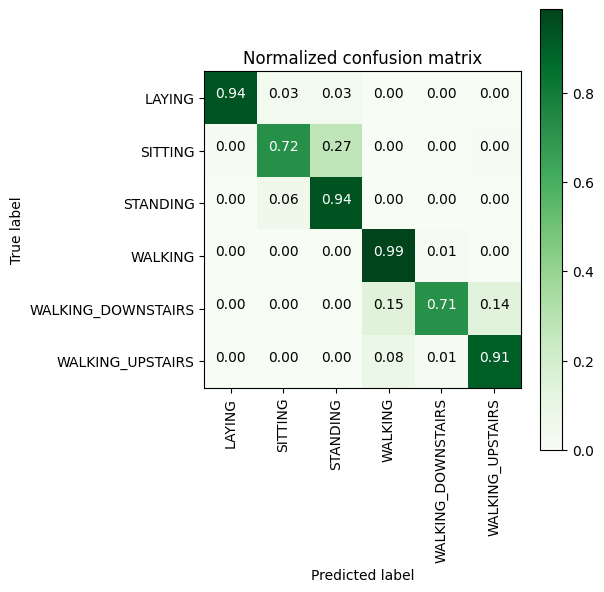

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.94      0.97       537
           SITTING       0.88      0.72      0.79       491
          STANDING       0.77      0.94      0.85       532
           WALKING       0.83      0.99      0.90       496
WALKING_DOWNSTAIRS       0.97      0.71      0.82       420
  WALKING_UPSTAIRS       0.87      0.91      0.89       471

          accuracy                           0.87      2947
         macro avg       0.89      0.87      0.87      2947
      weighted avg       0.88      0.87      0.87      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=9,
                                      weights='distance'))])


==> Best parameters:
	Parameters of best estimator : {'model__metric': 'manh

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline([
   ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('model', KNeighborsClassifier())   # 'model' is our step name
])
parameters_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11],  # Odd numbers to avoid ties
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan'] # Euclidean is standard, Manhattan is grid-like
}

# --- 3. Set up your GridSearchCV ---
print("Running GridSearchCV for K-Nearest Neighbors (KNN)...")

knn_grid = GridSearchCV(
    knn_pipeline,               # <-- Pass the KNN pipeline
    param_grid=parameters_knn,  # <-- Pass the KNN parameters
    cv=3,                       # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                   # Use all available cores
)

# --- 4. Call your function (no changes needed) ---
# This will test all 20 combinations (5 neighbors * 2 weights * 2 metrics)
# and find the single best-performing KNN model.

knn_grid_results = perform_model(
    knn_grid, 
    X_train, 
     y_train, 
     X_test, 
     y_test, 
     class_labels=labels
)

print_grid_search_attributes(knn_grid_results['model'])

Preprocessing data...
Running PCA...
Running LDA...


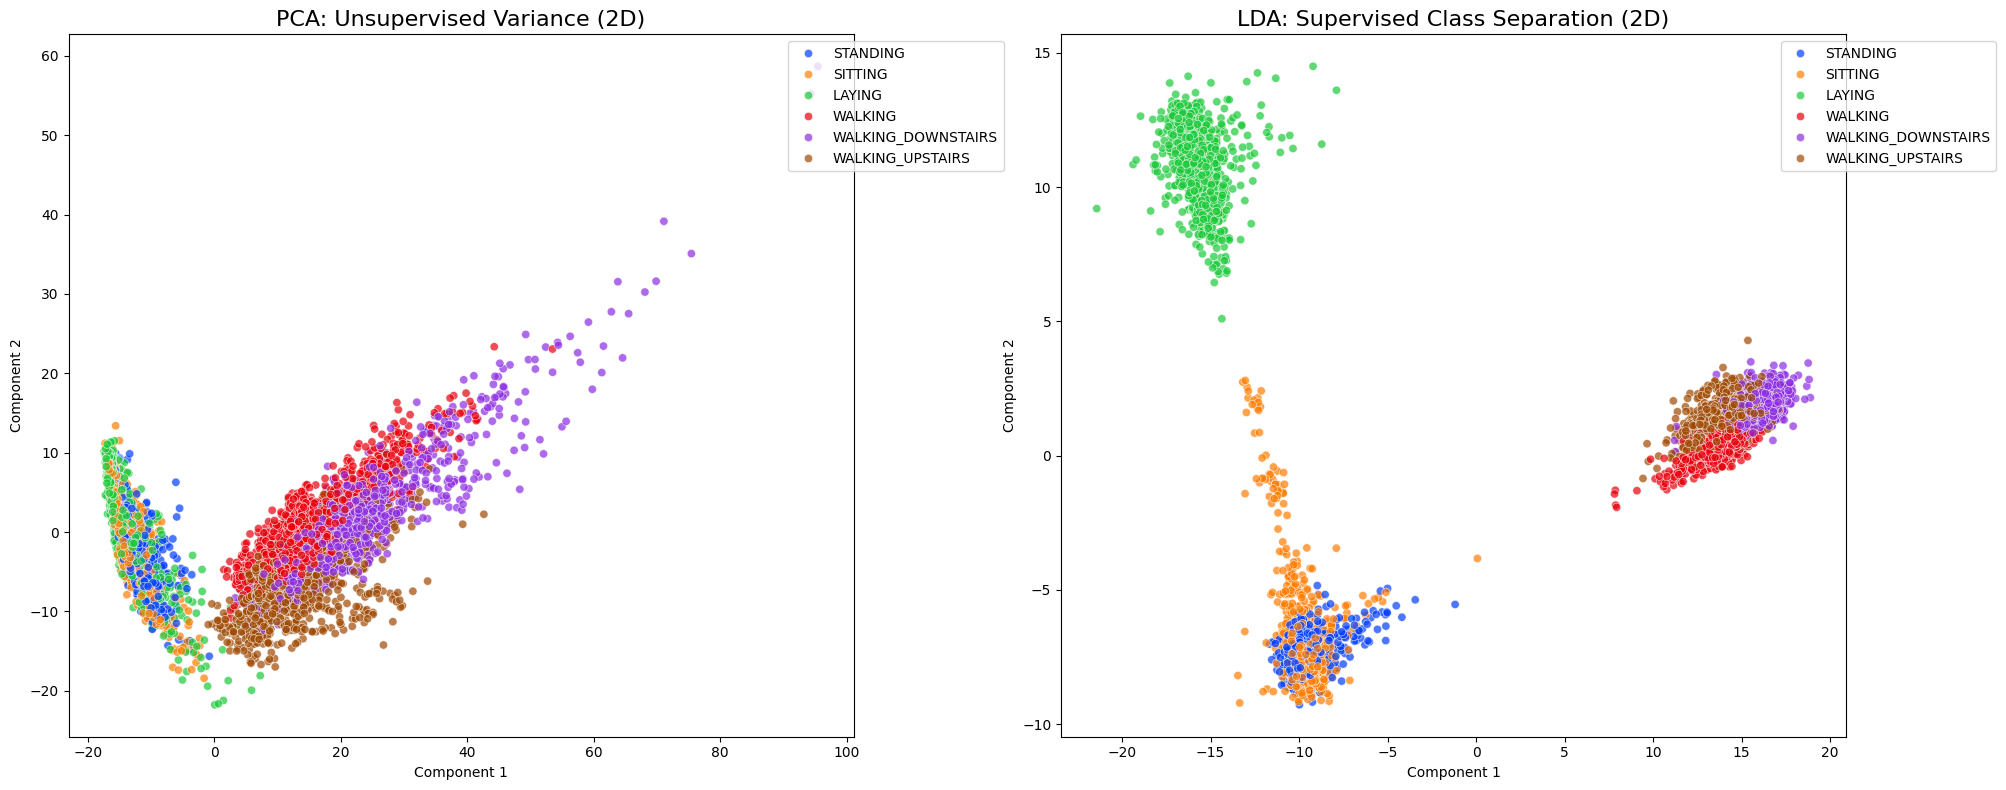

In [6]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- 1. Prepare the Data ---
# We use the full training set for this visualization
print("Preprocessing data...")

# Standard Scaling is CRITICAL for PCA and LDA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# --- 2. Apply PCA (Unsupervised) ---
# We ask for 2 components so we can make a 2D X/Y plot
print("Running PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 3. Apply LDA (Supervised) ---
# LDA needs labels (y_train) to find the best separation
print("Running LDA...")
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_train)

# --- 4. Organize Data for Plotting ---
# Create nice DataFrames to make Seaborn happy
df_pca = pd.DataFrame({
    'Component 1': X_pca[:, 0],
    'Component 2': X_pca[:, 1],
    'Activity': train['ActivityName'] # Use the text labels for the legend
})

df_lda = pd.DataFrame({
    'Component 1': X_lda[:, 0],
    'Component 2': X_lda[:, 1],
    'Activity': train['ActivityName']
})

# --- 5. Plot Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA
sns.scatterplot(
    data=df_pca, x='Component 1', y='Component 2', 
    hue='Activity', alpha=0.7, palette='bright', ax=axes[0]
)
axes[0].set_title('PCA: Unsupervised Variance (2D)', fontsize=16)
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Plot LDA
sns.scatterplot(
    data=df_lda, x='Component 1', y='Component 2', 
    hue='Activity', alpha=0.7, palette='bright', ax=axes[1]
)
axes[1].set_title('LDA: Supervised Class Separation (2D)', fontsize=16)
axes[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

Running GridSearchCV for KNN without Dimensionality Reduction...
Training the KNN (No DR) model..
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Done....!

==> Training time:- 0:00:17.757438

Predicting test data
Done....!

==> Testing time:- 0:00:01.198045

==> Accuracy:- 0.9141499830335935


 ********Confusion Matrix********

 [[530   6   1   0   0   0]
 [  1 404  85   0   0   1]
 [  0  18 514   0   0   0]
 [  0   0   0 489   4   3]
 [  0   0   0  42 322  56]
 [  0   0   0  35   1 435]]


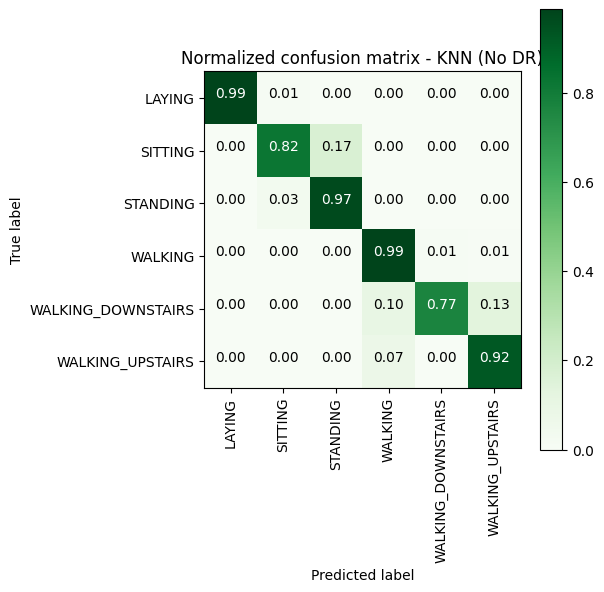

****************| Classification Report - KNN (No DR) |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       537
           SITTING       0.94      0.82      0.88       491
          STANDING       0.86      0.97      0.91       532
           WALKING       0.86      0.99      0.92       496
WALKING_DOWNSTAIRS       0.98      0.77      0.86       420
  WALKING_UPSTAIRS       0.88      0.92      0.90       471

          accuracy                           0.91      2947
         macro avg       0.92      0.91      0.91      2947
      weighted avg       0.92      0.91      0.91      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=11,
                                      weights='distance'))])


==> Best parameters:
	Parameters of best estimator : {'model__metric': 'manhattan', 'model__n

C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.85310275 0.85446301 0.86344    0.86411993 0.86888112 0.86874501
 0.87010516 0.86996916 0.87024133 0.87105738        nan 0.85378119
        nan 0.85990258        nan 0.86806479        nan 0.87132871
        nan 0.87105666]
  warnings.warn(


Done....!

==> Training time:- 0:00:08.077140

Predicting test data
Done....!

==> Testing time:- 0:00:00.201290

==> Accuracy:- 0.8737699355276553


 ********Confusion Matrix********

 [[503  17  17   0   0   0]
 [  2 353 134   0   0   2]
 [  0  30 502   0   0   0]
 [  0   0   0 490   5   1]
 [  0   0   0  61 300  59]
 [  0   0   0  39   5 427]]


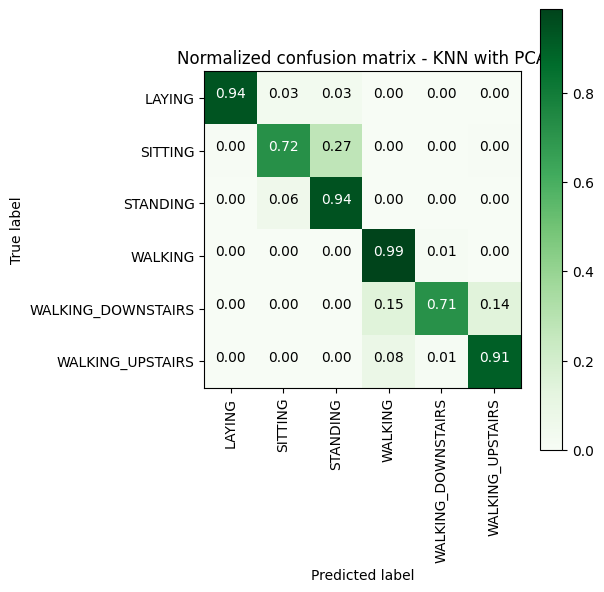

****************| Classification Report - KNN with PCA |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.94      0.97       537
           SITTING       0.88      0.72      0.79       491
          STANDING       0.77      0.94      0.85       532
           WALKING       0.83      0.99      0.90       496
WALKING_DOWNSTAIRS       0.97      0.71      0.82       420
  WALKING_UPSTAIRS       0.87      0.91      0.89       471

          accuracy                           0.87      2947
         macro avg       0.89      0.87      0.87      2947
      weighted avg       0.88      0.87      0.87      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', PCA(n_components=0.95)),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=9,
                                      weights='distance'))])


==> Best parameters:
	Parameters of best

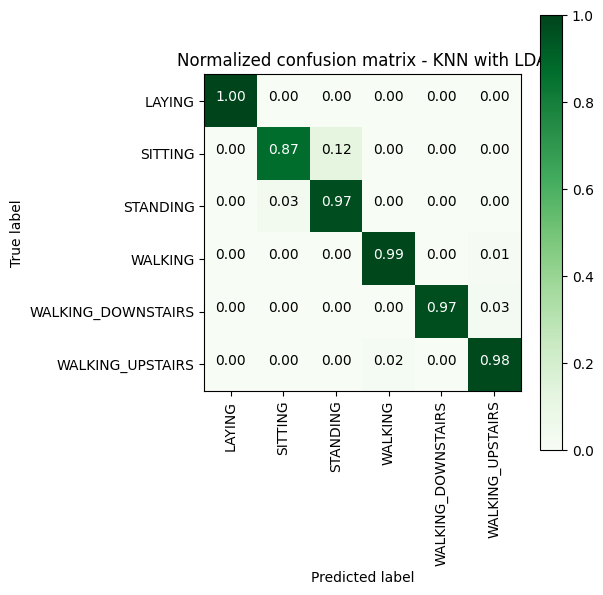

****************| Classification Report - KNN with LDA |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.87      0.91       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.98      0.99      0.98       496
WALKING_DOWNSTAIRS       1.00      0.97      0.99       420
  WALKING_UPSTAIRS       0.96      0.98      0.97       471

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.97      0.96      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', LinearDiscriminantAnalysis(n_components=5)),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=9,
                                      weights='distance'))])


==> Best parameters:

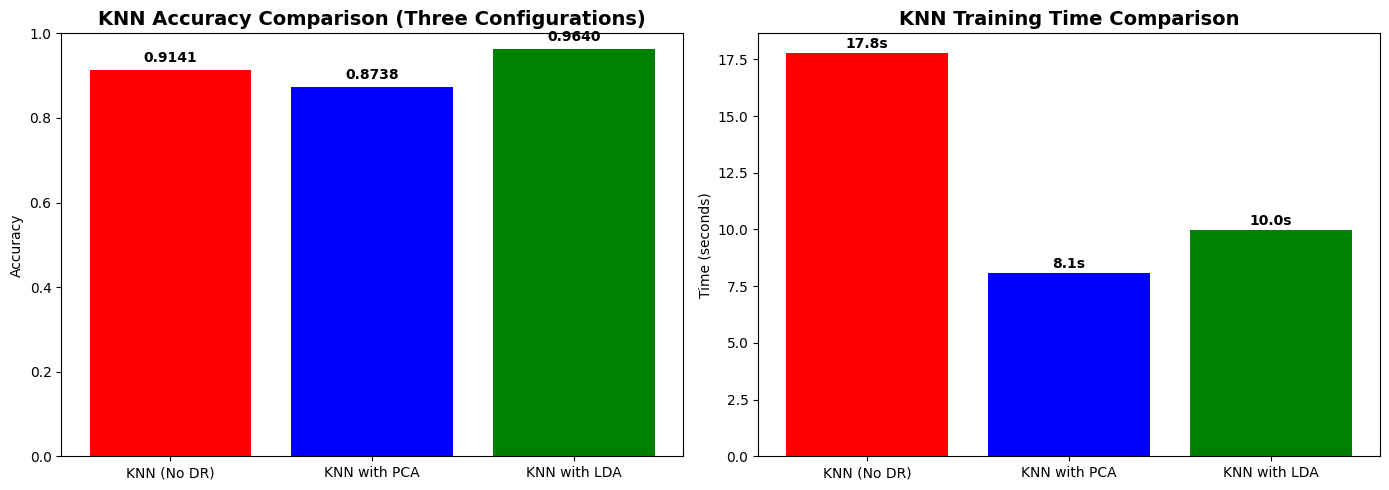


DETAILED THREE-WAY KNN COMPARISON
Model           | Accuracy | Training Time | Best Parameters
--------------------------------------------------------------------------------
KNN (No DR)     | 0.9141   | 17.8        s | k=11, weights=distance, metric=manhattan
KNN + PCA       | 0.8738   | 8.1         s | k=9, weights=distance, metric=manhattan
KNN + LDA       | 0.9640   | 10.0        s | k=9, weights=distance, metric=manhattan

🏆 Best performing KNN model: KNN with LDA (Accuracy: 0.9640)

THREE-WAY CONFUSION MATRIX COMPARISON - KNN MODELS


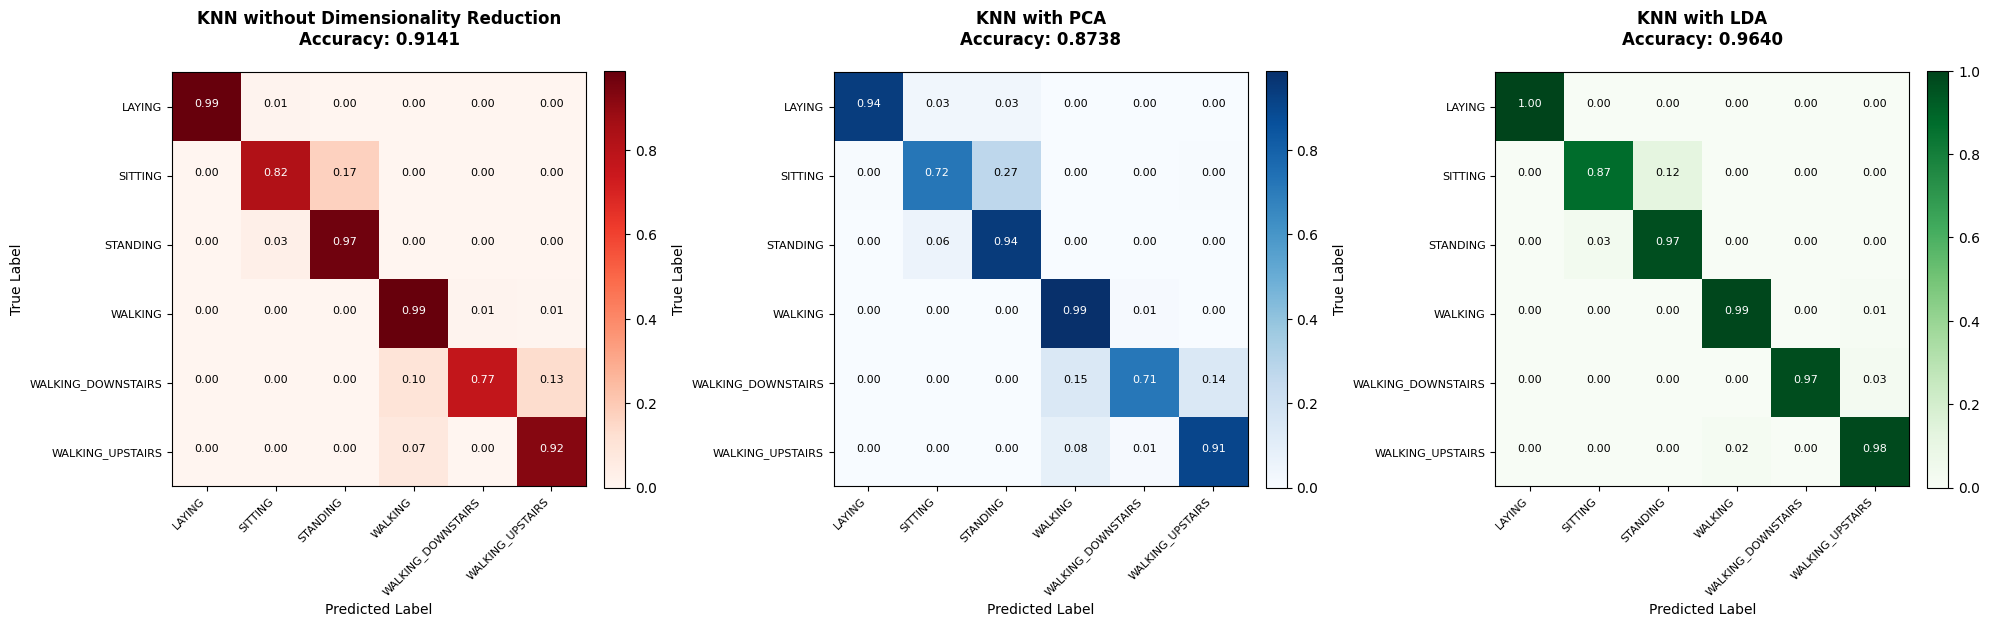


COMPREHENSIVE PERFORMANCE ANALYSIS
Performance improvements relative to KNN without dimensionality reduction:
  • KNN with PCA:  -0.0404 (-4.04%)
  • KNN with LDA:  +0.0499 (+4.99%)

Training efficiency:
  • Fastest model: KNN with PCA (8.1s)

FINAL COMPREHENSIVE RECOMMENDATION
🏆 STRONGLY RECOMMEND: KNN with Linear Discriminant Analysis (LDA)
   • Highest accuracy: 0.9640
   • Significant improvement over baseline: +4.99%
   • Comparable or faster training time


In [7]:
# Add this cell after your existing imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- KNN Implementation ---
def perform_knn_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, 
                     print_cm=True, cm_cmap=plt.cm.Greens, model_name="KNN"):
    """
    Perform KNN model training and evaluation
    """
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print(f'Training the {model_name} model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> Training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> Testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusion matrix
    plt.figure(figsize=(6,6))
    plt.grid(False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, 
                         title=f'Normalized confusion matrix - {model_name}', cmap=cm_cmap)
    plt.show()
    
    # get classification report
    print(f'****************| Classification Report - {model_name} |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    results['model_name'] = model_name
    
    return results

# Define KNN parameters for grid search
knn_parameters = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

# --- KNN without Dimensionality Reduction ---
print("Running GridSearchCV for KNN without Dimensionality Reduction...")

# Create simple KNN pipeline (just scaler + KNN)
simple_knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

# Setup GridSearchCV for simple KNN
knn_grid_simple = GridSearchCV(
    simple_knn_pipeline,
    param_grid=knn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run simple KNN model
knn_grid_simple_results = perform_knn_model(
    knn_grid_simple, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="KNN (No DR)"
)

print_grid_search_attributes(knn_grid_simple_results['model'])

# --- KNN with PCA ---
print("\nRunning GridSearchCV for PCA + KNN...")

# Create PCA pipeline for KNN
pca_knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', PCA(n_components=0.95)),
    ('model', KNeighborsClassifier())
])

# Setup GridSearchCV for KNN with PCA
knn_grid_pca = GridSearchCV(
    pca_knn_pipeline,
    param_grid=knn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run KNN model with PCA
knn_grid_pca_results = perform_knn_model(
    knn_grid_pca, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="KNN with PCA"
)

print_grid_search_attributes(knn_grid_pca_results['model'])

# --- KNN with LDA ---
print("\nRunning GridSearchCV for LDA + KNN...")

# Create LDA pipeline for KNN
lda_knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', LDA(n_components=5)),  # LDA for dimensionality reduction
    ('model', KNeighborsClassifier())
])

# Setup GridSearchCV for LDA + KNN
knn_grid_lda = GridSearchCV(
    lda_knn_pipeline,
    param_grid=knn_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run LDA + KNN model
knn_grid_lda_results = perform_knn_model(
    knn_grid_lda, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="KNN with LDA"
)

print_grid_search_attributes(knn_grid_lda_results['model'])

# --- Three-Way KNN Comparison ---
print("\n" + "="*60)
print("THREE-WAY KNN MODEL COMPARISON")
print("="*60)
print(f"KNN without DR:  {knn_grid_simple_results['accuracy']:.4f}")
print(f"KNN with PCA:    {knn_grid_pca_results['accuracy']:.4f}")
print(f"KNN with LDA:    {knn_grid_lda_results['accuracy']:.4f}")

# Extract best parameters for comparison
simple_best_params = knn_grid_simple_results['model'].best_params_
pca_best_params = knn_grid_pca_results['model'].best_params_
lda_best_params = knn_grid_lda_results['model'].best_params_

print("\nBest Parameters:")
print(f"KNN without DR: {simple_best_params}")
print(f"PCA + KNN:      {pca_best_params}")
print(f"LDA + KNN:      {lda_best_params}")

# --- Three-Way KNN Comparison Visualization ---
knn_models = ['KNN (No DR)', 'KNN with PCA', 'KNN with LDA']
knn_accuracies = [
    knn_grid_simple_results['accuracy'],
    knn_grid_pca_results['accuracy'],
    knn_grid_lda_results['accuracy']
]

knn_training_times = [
    knn_grid_simple_results['training_time'].total_seconds(),
    knn_grid_pca_results['training_time'].total_seconds(),
    knn_grid_lda_results['training_time'].total_seconds()
]

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = ['red', 'blue', 'green']
bars1 = ax1.bar(knn_models, knn_accuracies, color=colors)
ax1.set_title('KNN Accuracy Comparison (Three Configurations)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, knn_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Training time comparison  
bars2 = ax2.bar(knn_models, knn_training_times, color=colors)
ax2.set_title('KNN Training Time Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (seconds)')
for bar, time in zip(bars2, knn_training_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed comparison
print("\n" + "="*80)
print("DETAILED THREE-WAY KNN COMPARISON")
print("="*80)
print(f"{'Model':<15} | {'Accuracy':<8} | {'Training Time':<12} | Best Parameters")
print("-" * 80)

simple_params_str = f"k={simple_best_params['model__n_neighbors']}, weights={simple_best_params['model__weights']}, metric={simple_best_params['model__metric']}"
pca_params_str = f"k={pca_best_params['model__n_neighbors']}, weights={pca_best_params['model__weights']}, metric={pca_best_params['model__metric']}"
lda_params_str = f"k={lda_best_params['model__n_neighbors']}, weights={lda_best_params['model__weights']}, metric={lda_best_params['model__metric']}"

print(f"{'KNN (No DR)':<15} | {knn_accuracies[0]:<8.4f} | {knn_training_times[0]:<12.1f}s | {simple_params_str}")
print(f"{'KNN + PCA':<15} | {knn_accuracies[1]:<8.4f} | {knn_training_times[1]:<12.1f}s | {pca_params_str}")
print(f"{'KNN + LDA':<15} | {knn_accuracies[2]:<8.4f} | {knn_training_times[2]:<12.1f}s | {lda_params_str}")

# Determine winner
best_accuracy = max(knn_accuracies)
best_model_index = knn_accuracies.index(best_accuracy)
winner = knn_models[best_model_index]

print(f"\n🏆 Best performing KNN model: {winner} (Accuracy: {best_accuracy:.4f})")
print("="*80)

# --- Three-Way Confusion Matrix Comparison ---
print("\n" + "="*80)
print("THREE-WAY CONFUSION MATRIX COMPARISON - KNN MODELS")
print("="*80)

# Get confusion matrices
cm_simple = knn_grid_simple_results['confusion_matrix']
cm_pca = knn_grid_pca_results['confusion_matrix']
cm_lda = knn_grid_lda_results['confusion_matrix']

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Normalize confusion matrices
cm_simple_normalized = cm_simple.astype('float') / cm_simple.sum(axis=1)[:, np.newaxis]
cm_pca_normalized = cm_pca.astype('float') / cm_pca.sum(axis=1)[:, np.newaxis]
cm_lda_normalized = cm_lda.astype('float') / cm_lda.sum(axis=1)[:, np.newaxis]

# Plot Simple KNN Confusion Matrix
im1 = ax1.imshow(cm_simple_normalized, interpolation='nearest', cmap=plt.cm.Reds)
ax1.set_title('KNN without Dimensionality Reduction\nAccuracy: {:.4f}'.format(knn_grid_simple_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=10)
ax1.set_ylabel('True Label', fontsize=10)
tick_marks = np.arange(len(labels))
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(labels, fontsize=8)

# Plot PCA KNN Confusion Matrix
im2 = ax2.imshow(cm_pca_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('KNN with PCA\nAccuracy: {:.4f}'.format(knn_grid_pca_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=10)
ax2.set_ylabel('True Label', fontsize=10)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(labels, fontsize=8)

# Plot LDA KNN Confusion Matrix
im3 = ax3.imshow(cm_lda_normalized, interpolation='nearest', cmap=plt.cm.Greens)
ax3.set_title('KNN with LDA\nAccuracy: {:.4f}'.format(knn_grid_lda_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax3.set_xlabel('Predicted Label', fontsize=10)
ax3.set_ylabel('True Label', fontsize=10)
ax3.set_xticks(tick_marks)
ax3.set_yticks(tick_marks)
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax3.set_yticklabels(labels, fontsize=8)

# Add text annotations for all matrices
for ax, cm_norm in zip([ax1, ax2, ax3], [cm_simple_normalized, cm_pca_normalized, cm_lda_normalized]):
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black",
                 fontsize=8)

# Add colorbars
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Comprehensive Performance Analysis ---
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*80)

# Calculate improvements relative to baseline (no DR)
baseline_accuracy = knn_grid_simple_results['accuracy']
pca_improvement = knn_grid_pca_results['accuracy'] - baseline_accuracy
lda_improvement = knn_grid_lda_results['accuracy'] - baseline_accuracy

print(f"Performance improvements relative to KNN without dimensionality reduction:")
print(f"  • KNN with PCA:  {pca_improvement:+.4f} ({pca_improvement*100:+.2f}%)")
print(f"  • KNN with LDA:  {lda_improvement:+.4f} ({lda_improvement*100:+.2f}%)")

# Training time comparison
fastest_time = min(knn_training_times)
fastest_model_index = knn_training_times.index(fastest_time)
fastest_model = knn_models[fastest_model_index]

print(f"\nTraining efficiency:")
print(f"  • Fastest model: {fastest_model} ({fastest_time:.1f}s)")

# Final comprehensive recommendation
print("\n" + "="*80)
print("FINAL COMPREHENSIVE RECOMMENDATION")
print("="*80)

if lda_improvement > 0 and knn_grid_lda_results['accuracy'] == best_accuracy:
    print("🏆 STRONGLY RECOMMEND: KNN with Linear Discriminant Analysis (LDA)")
    print(f"   • Highest accuracy: {knn_grid_lda_results['accuracy']:.4f}")
    print(f"   • Significant improvement over baseline: {lda_improvement*100:+.2f}%")
    if knn_training_times[2] <= knn_training_times[0]:
        print(f"   • Comparable or faster training time")
elif pca_improvement > 0 and knn_grid_pca_results['accuracy'] == best_accuracy:
    print("🏆 RECOMMEND: KNN with Principal Component Analysis (PCA)")
    print(f"   • Good accuracy: {knn_grid_pca_results['accuracy']:.4f}")
    print(f"   • Moderate improvement over baseline: {pca_improvement*100:+.2f}%")
else:
    print("🏆 CONSIDER: KNN without Dimensionality Reduction")
    print(f"   • Simpler implementation")
    print(f"   • No additional preprocessing steps required")

print("="*80)

Running GridSearchCV for SVM without Dimensionality Reduction...
Training the SVM (No DR) model..
Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Done....!

==> Training time:- 0:08:23.642059

Predicting test data
Done....!

==> Testing time:- 0:00:00.940252

==> Accuracy:- 0.9616559212758737


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  1 436  53   0   0   1]
 [  0  18 514   0   0   0]
 [  0   0   0 495   1   0]
 [  0   0   0   6 399  15]
 [  0   0   0  16   2 453]]


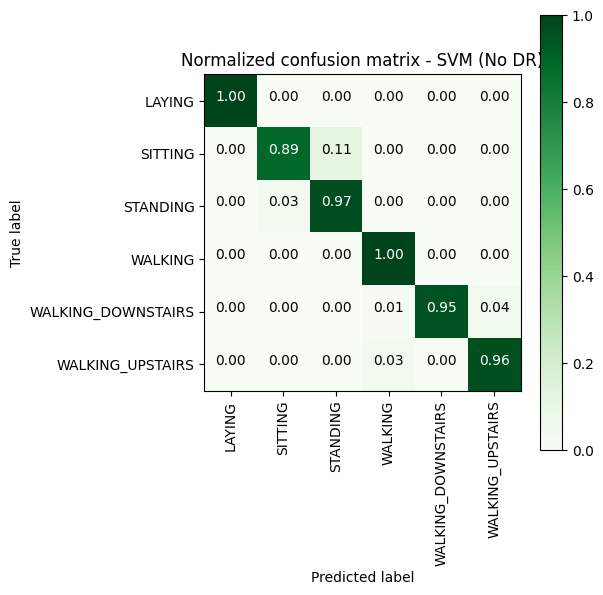

****************| Classification Report - SVM (No DR) |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(C=0.1, cache_size=500, kernel='linear'))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 0.1, 'model__cache_size': 500, 'model__kernel': 'linear'}

==> No. of CrossValidation sets:
	Total numbre of cross 

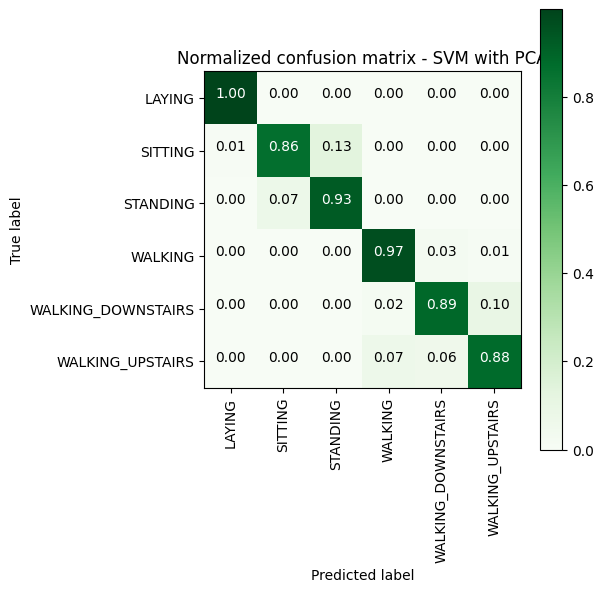

****************| Classification Report - SVM with PCA |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.92      0.86      0.89       491
          STANDING       0.88      0.93      0.90       532
           WALKING       0.93      0.97      0.95       496
WALKING_DOWNSTAIRS       0.90      0.89      0.90       420
  WALKING_UPSTAIRS       0.90      0.88      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', PCA(n_components=0.95)),
                ('model', SVC(C=1, cache_size=500, kernel='linear'))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 1, 'model__cache_size': 500, 'model__kernel': 'linear'}

==> No

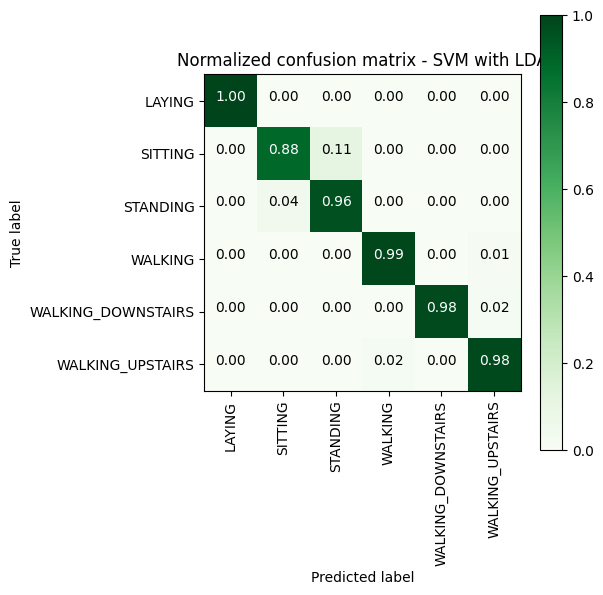

****************| Classification Report - SVM with LDA |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.88      0.92       491
          STANDING       0.90      0.96      0.93       532
           WALKING       0.98      0.99      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.97      0.98      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.96      0.97      2947
      weighted avg       0.97      0.97      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', LinearDiscriminantAnalysis(n_components=5)),
                ('model', SVC(C=1, cache_size=500))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 1, 'model__cache_size': 500, 'model__gamma': 'scale', 'model

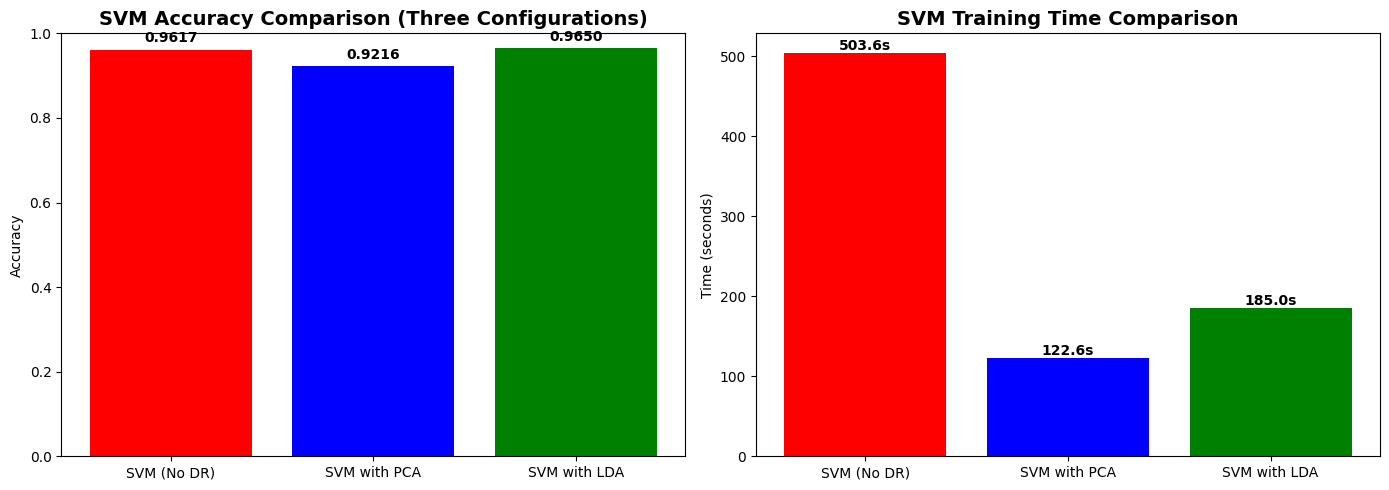


DETAILED THREE-WAY SVM COMPARISON
Model           | Accuracy | Training Time | Best Parameters
--------------------------------------------------------------------------------
SVM (No DR)     | 0.9617   | 503.6       s | kernel=linear, C=0.1
SVM + PCA       | 0.9216   | 122.6       s | kernel=linear, C=1
SVM + LDA       | 0.9650   | 185.0       s | kernel=rbf, C=1, gamma=scale

🏆 Best performing SVM model: SVM with LDA (Accuracy: 0.9650)

THREE-WAY CONFUSION MATRIX COMPARISON - SVM MODELS


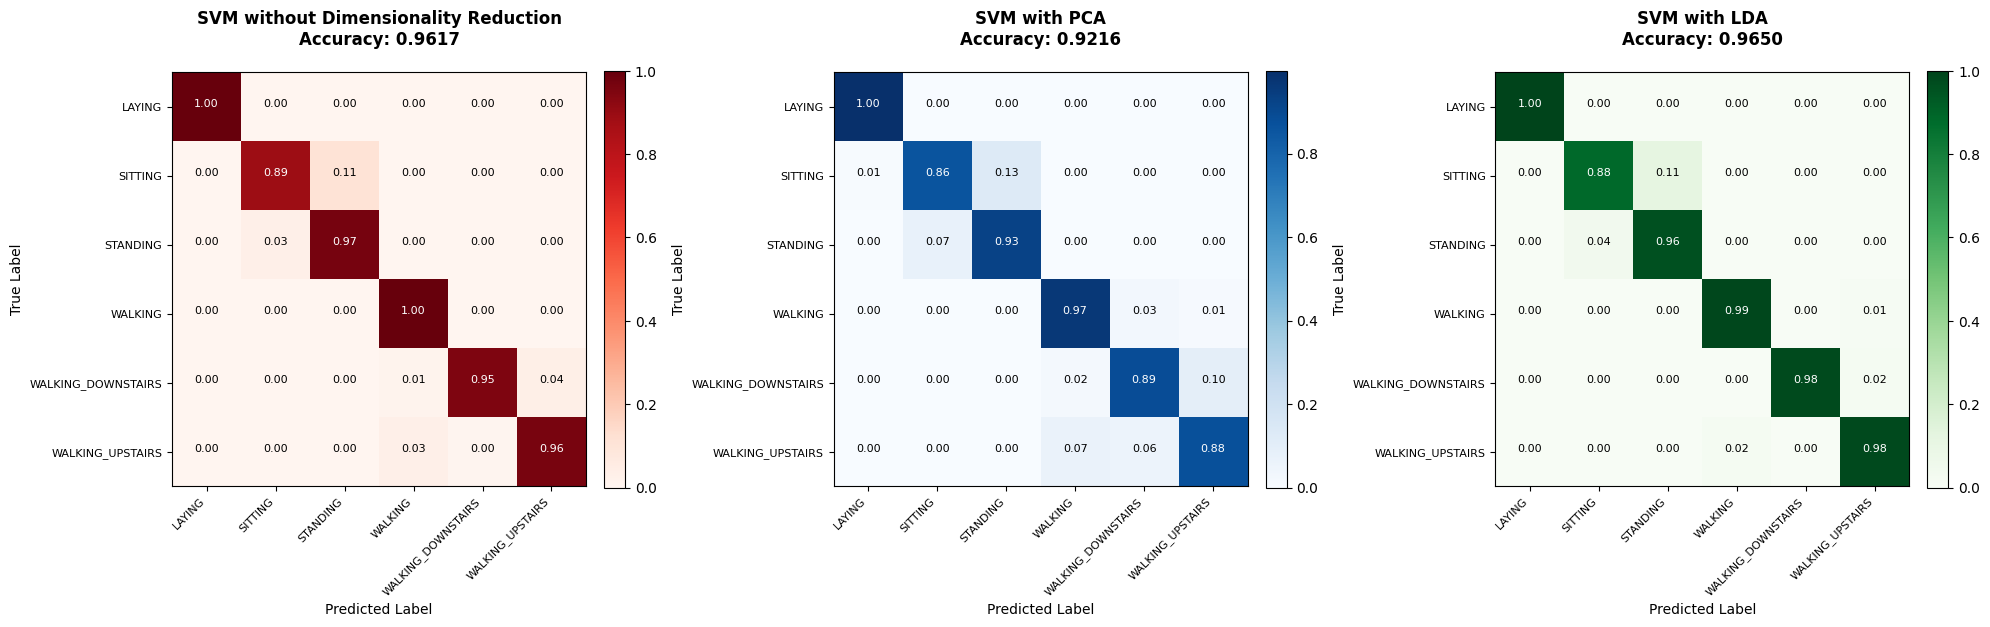


COMPREHENSIVE PERFORMANCE ANALYSIS
Performance improvements relative to SVM without dimensionality reduction:
  • SVM with PCA:  -0.0400 (-4.00%)
  • SVM with LDA:  +0.0034 (+0.34%)

Training efficiency:
  • Fastest model: SVM with PCA (122.6s)

FINAL COMPREHENSIVE RECOMMENDATION
🏆 STRONGLY RECOMMEND: SVM with Linear Discriminant Analysis (LDA)
   • Highest accuracy: 0.9650
   • Significant improvement over baseline: +0.34%
   • Comparable or faster training time

CROSS-ALGORITHM COMPARISON: SVM vs KNN
Best SVM Model: SVM with LDA (Accuracy: 0.9650)
Best KNN Model: KNN with LDA (Accuracy: 0.9640)

🏆 OVERALL WINNER: SVM (SVM with LDA)
   • SVM outperforms KNN by 0.0010 (+0.10%)


In [8]:
# Add this cell after your existing imports
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- SVM Implementation ---
def perform_svm_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, 
                     print_cm=True, cm_cmap=plt.cm.Greens, model_name="SVM"):
    """
    Perform SVM model training and evaluation
    """
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print(f'Training the {model_name} model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> Training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> Testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusion matrix
    plt.figure(figsize=(6,6))
    plt.grid(False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, 
                         title=f'Normalized confusion matrix - {model_name}', cmap=cm_cmap)
    plt.show()
    
    # get classification report
    print(f'****************| Classification Report - {model_name} |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    results['model_name'] = model_name
    
    return results

# Define SVM parameters for grid search
svm_parameters = [
    {
        'model__kernel': ['linear'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__cache_size': [500]
    },
    {
        'model__kernel': ['rbf'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'model__cache_size': [500]
    },
    {
        'model__kernel': ['poly'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__degree': [2, 3, 4],
        'model__gamma': ['scale', 'auto'],
        'model__cache_size': [500]
    }
]

# --- SVM without Dimensionality Reduction ---
print("Running GridSearchCV for SVM without Dimensionality Reduction...")

# Create simple SVM pipeline (just scaler + SVM)
simple_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])

# Setup GridSearchCV for simple SVM
svm_grid_simple = GridSearchCV(
    simple_svm_pipeline,
    param_grid=svm_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run simple SVM model
svm_grid_simple_results = perform_svm_model(
    svm_grid_simple, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="SVM (No DR)"
)

print_grid_search_attributes(svm_grid_simple_results['model'])

# --- SVM with PCA ---
print("\nRunning GridSearchCV for PCA + SVM...")

# Create PCA pipeline for SVM
pca_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', PCA(n_components=0.95)),
    ('model', SVC())
])

# Setup GridSearchCV for SVM with PCA
svm_grid_pca = GridSearchCV(
    pca_svm_pipeline,
    param_grid=svm_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run SVM model with PCA
svm_grid_pca_results = perform_svm_model(
    svm_grid_pca, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="SVM with PCA"
)

print_grid_search_attributes(svm_grid_pca_results['model'])

# --- SVM with LDA ---
print("\nRunning GridSearchCV for LDA + SVM...")

# Create LDA pipeline for SVM
lda_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', LDA(n_components=5)),  # LDA for dimensionality reduction
    ('model', SVC())
])

# Setup GridSearchCV for LDA + SVM
svm_grid_lda = GridSearchCV(
    lda_svm_pipeline,
    param_grid=svm_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run LDA + SVM model
svm_grid_lda_results = perform_svm_model(
    svm_grid_lda, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="SVM with LDA"
)

print_grid_search_attributes(svm_grid_lda_results['model'])

# --- Three-Way SVM Comparison ---
print("\n" + "="*60)
print("THREE-WAY SVM MODEL COMPARISON")
print("="*60)
print(f"SVM without DR:  {svm_grid_simple_results['accuracy']:.4f}")
print(f"SVM with PCA:    {svm_grid_pca_results['accuracy']:.4f}")
print(f"SVM with LDA:    {svm_grid_lda_results['accuracy']:.4f}")

# Extract best parameters for comparison
simple_best_params = svm_grid_simple_results['model'].best_params_
pca_best_params = svm_grid_pca_results['model'].best_params_
lda_best_params = svm_grid_lda_results['model'].best_params_

print("\nBest Parameters:")
print(f"SVM without DR: {simple_best_params}")
print(f"PCA + SVM:      {pca_best_params}")
print(f"LDA + SVM:      {lda_best_params}")

# --- Three-Way SVM Comparison Visualization ---
svm_models = ['SVM (No DR)', 'SVM with PCA', 'SVM with LDA']
svm_accuracies = [
    svm_grid_simple_results['accuracy'],
    svm_grid_pca_results['accuracy'],
    svm_grid_lda_results['accuracy']
]

svm_training_times = [
    svm_grid_simple_results['training_time'].total_seconds(),
    svm_grid_pca_results['training_time'].total_seconds(),
    svm_grid_lda_results['training_time'].total_seconds()
]

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = ['red', 'blue', 'green']
bars1 = ax1.bar(svm_models, svm_accuracies, color=colors)
ax1.set_title('SVM Accuracy Comparison (Three Configurations)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, svm_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Training time comparison  
bars2 = ax2.bar(svm_models, svm_training_times, color=colors)
ax2.set_title('SVM Training Time Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (seconds)')
for bar, time in zip(bars2, svm_training_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed comparison
print("\n" + "="*80)
print("DETAILED THREE-WAY SVM COMPARISON")
print("="*80)
print(f"{'Model':<15} | {'Accuracy':<8} | {'Training Time':<12} | Best Parameters")
print("-" * 80)

simple_params_str = f"kernel={simple_best_params['model__kernel']}, C={simple_best_params['model__C']}"
pca_params_str = f"kernel={pca_best_params['model__kernel']}, C={pca_best_params['model__C']}"
lda_params_str = f"kernel={lda_best_params['model__kernel']}, C={lda_best_params['model__C']}"

# Add gamma if present in best parameters
if 'model__gamma' in simple_best_params:
    simple_params_str += f", gamma={simple_best_params['model__gamma']}"
if 'model__gamma' in pca_best_params:
    pca_params_str += f", gamma={pca_best_params['model__gamma']}"
if 'model__gamma' in lda_best_params:
    lda_params_str += f", gamma={lda_best_params['model__gamma']}"

print(f"{'SVM (No DR)':<15} | {svm_accuracies[0]:<8.4f} | {svm_training_times[0]:<12.1f}s | {simple_params_str}")
print(f"{'SVM + PCA':<15} | {svm_accuracies[1]:<8.4f} | {svm_training_times[1]:<12.1f}s | {pca_params_str}")
print(f"{'SVM + LDA':<15} | {svm_accuracies[2]:<8.4f} | {svm_training_times[2]:<12.1f}s | {lda_params_str}")

# Determine winner
best_accuracy = max(svm_accuracies)
best_model_index = svm_accuracies.index(best_accuracy)
winner = svm_models[best_model_index]

print(f"\n🏆 Best performing SVM model: {winner} (Accuracy: {best_accuracy:.4f})")
print("="*80)

# --- Three-Way Confusion Matrix Comparison ---
print("\n" + "="*80)
print("THREE-WAY CONFUSION MATRIX COMPARISON - SVM MODELS")
print("="*80)

# Get confusion matrices
cm_simple = svm_grid_simple_results['confusion_matrix']
cm_pca = svm_grid_pca_results['confusion_matrix']
cm_lda = svm_grid_lda_results['confusion_matrix']

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Normalize confusion matrices
cm_simple_normalized = cm_simple.astype('float') / cm_simple.sum(axis=1)[:, np.newaxis]
cm_pca_normalized = cm_pca.astype('float') / cm_pca.sum(axis=1)[:, np.newaxis]
cm_lda_normalized = cm_lda.astype('float') / cm_lda.sum(axis=1)[:, np.newaxis]

# Plot Simple SVM Confusion Matrix
im1 = ax1.imshow(cm_simple_normalized, interpolation='nearest', cmap=plt.cm.Reds)
ax1.set_title('SVM without Dimensionality Reduction\nAccuracy: {:.4f}'.format(svm_grid_simple_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=10)
ax1.set_ylabel('True Label', fontsize=10)
tick_marks = np.arange(len(labels))
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(labels, fontsize=8)

# Plot PCA SVM Confusion Matrix
im2 = ax2.imshow(cm_pca_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('SVM with PCA\nAccuracy: {:.4f}'.format(svm_grid_pca_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=10)
ax2.set_ylabel('True Label', fontsize=10)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(labels, fontsize=8)

# Plot LDA SVM Confusion Matrix
im3 = ax3.imshow(cm_lda_normalized, interpolation='nearest', cmap=plt.cm.Greens)
ax3.set_title('SVM with LDA\nAccuracy: {:.4f}'.format(svm_grid_lda_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax3.set_xlabel('Predicted Label', fontsize=10)
ax3.set_ylabel('True Label', fontsize=10)
ax3.set_xticks(tick_marks)
ax3.set_yticks(tick_marks)
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax3.set_yticklabels(labels, fontsize=8)

# Add text annotations for all matrices
for ax, cm_norm in zip([ax1, ax2, ax3], [cm_simple_normalized, cm_pca_normalized, cm_lda_normalized]):
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black",
                 fontsize=8)

# Add colorbars
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Comprehensive Performance Analysis ---
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*80)

# Calculate improvements relative to baseline (no DR)
baseline_accuracy = svm_grid_simple_results['accuracy']
pca_improvement = svm_grid_pca_results['accuracy'] - baseline_accuracy
lda_improvement = svm_grid_lda_results['accuracy'] - baseline_accuracy

print(f"Performance improvements relative to SVM without dimensionality reduction:")
print(f"  • SVM with PCA:  {pca_improvement:+.4f} ({pca_improvement*100:+.2f}%)")
print(f"  • SVM with LDA:  {lda_improvement:+.4f} ({lda_improvement*100:+.2f}%)")

# Training time comparison
fastest_time = min(svm_training_times)
fastest_model_index = svm_training_times.index(fastest_time)
fastest_model = svm_models[fastest_model_index]

print(f"\nTraining efficiency:")
print(f"  • Fastest model: {fastest_model} ({fastest_time:.1f}s)")

# Final comprehensive recommendation
print("\n" + "="*80)
print("FINAL COMPREHENSIVE RECOMMENDATION")
print("="*80)

if lda_improvement > 0 and svm_grid_lda_results['accuracy'] == best_accuracy:
    print("🏆 STRONGLY RECOMMEND: SVM with Linear Discriminant Analysis (LDA)")
    print(f"   • Highest accuracy: {svm_grid_lda_results['accuracy']:.4f}")
    print(f"   • Significant improvement over baseline: {lda_improvement*100:+.2f}%")
    if svm_training_times[2] <= svm_training_times[0]:
        print(f"   • Comparable or faster training time")
elif pca_improvement > 0 and svm_grid_pca_results['accuracy'] == best_accuracy:
    print("🏆 RECOMMEND: SVM with Principal Component Analysis (PCA)")
    print(f"   • Good accuracy: {svm_grid_pca_results['accuracy']:.4f}")
    print(f"   • Moderate improvement over baseline: {pca_improvement*100:+.2f}%")
else:
    print("🏆 CONSIDER: SVM without Dimensionality Reduction")
    print(f"   • Simpler implementation")
    print(f"   • No additional preprocessing steps required")

print("="*80)

# --- Cross-Algorithm Comparison (SVM vs KNN) ---
print("\n" + "="*80)
print("CROSS-ALGORITHM COMPARISON: SVM vs KNN")
print("="*80)

# Get best performing models from each algorithm
best_svm_accuracy = max(svm_accuracies)
best_knn_accuracy = max(knn_accuracies)  # Assuming you have KNN results

best_svm_model = svm_models[svm_accuracies.index(best_svm_accuracy)]
best_knn_model = knn_models[knn_accuracies.index(best_knn_accuracy)]

print(f"Best SVM Model: {best_svm_model} (Accuracy: {best_svm_accuracy:.4f})")
print(f"Best KNN Model: {best_knn_model} (Accuracy: {best_knn_accuracy:.4f})")

if best_svm_accuracy > best_knn_accuracy:
    print(f"\n🏆 OVERALL WINNER: SVM ({best_svm_model})")
    improvement = best_svm_accuracy - best_knn_accuracy
    print(f"   • SVM outperforms KNN by {improvement:.4f} ({improvement*100:+.2f}%)")
elif best_knn_accuracy > best_svm_accuracy:
    print(f"\n🏆 OVERALL WINNER: KNN ({best_knn_model})")
    improvement = best_knn_accuracy - best_svm_accuracy
    print(f"   • KNN outperforms SVM by {improvement:.4f} ({improvement*100:+.2f}%)")
else:
    print(f"\n🏆 TIE: Both algorithms achieved the same accuracy")

print("="*80)